# Algoritmo de Metropolis-Hastings
El algoritmo de Metropolis-Hastings se utiliza para hacer un muestreo de una funcion densidad de probabilidad complicada. Esta utiliza un distribucion conocida y un algoritmo para generar numeros aleatorios en el intervalo $[0,1)$.

Pasos del Algoritmo
1. Elegir un punto de partida inicial $x_0$.Definir el número de iteraciones $N$.

2. Proponer un nuevo estado: Generar un estado candidato x′ a partir de una distribución de propuesta q(x′∣xt​). Ejemplo común (caminata aleatoria): x′∼Normal(xt​,σ2), donde xt​ es el estado actual.
3. Calcular la tasa de aceptación (α): Se calcula la razon de probabilidad (qué tan probable es el nuevo punto frente al actual) y el ratio de Hastings (qué tan probable es moverse de ida y vuelta).
$$\alpha = \frac{P(x')}{P(x_t)} \cdot \frac{q(x_t|x')}{q(x'|x_t)}$$
(Como $P(x) \propto f(x)$, podemos usar $f(x)$):
$$\alpha = \frac{f(x')}{f(x_t)} \cdot \frac{q(x_t|x')}{q(x'|x_t)}$$
Si la distribución de propuesta es simétrica (por ejemplo, una Gaussiana, donde q(xt​∣x′)=q(x′∣xt​)), el ratio de Hastings es 1 y la fórmula se simplifica:> $$\alpha = \frac{f(x')}{f(x_t)}$$
4.  Decidir (Aceptar o Rechazar): Generar un número aleatorio u uniforme(0,1).Si u<min(1,α): se acepta el nuevo estado: $x_{t+1}​=x'$. Si no (u≥min(1,α)), se rechaza el nuevo estado y la cadena se queda en el mismo lugar: $x_{t+1}​=x_t​$.
5. Iterar.

Resultado: La colección de estados $\{x_0, x_1, \dots, x_N\}$ es una cadena de Markov. Después de desechar un número inicial de muestras (el "burn-in"), las muestras restantes $\{x_k, x_{k+1}, \dots, x_N\}$ son una aproximación de la distribución $P(x)$.

In [2]:
# cargar las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import norm
from scipy.stats import expon

## Ejemplo 1D

In [3]:
# funcion a integrar
def f(x):
  if x > -10:
    return np.exp(-x) * np.cos(x)**2
  else:
    return 0

# funcion "peso"
def p(x):
  """densidad exponecial"""
  return expon.pdf(x)

# MH
def metropolis_hastings(target_pdf, steps=5000, burn_in=1000):
  """Implementa el algoritmo de Metropolis-Hastings para una distribución gaussiana."""
  samples = []
  current_pos = 1.1

  for _ in range(steps):
    proposal_pos = np.random.normal(current_pos, 1.0) # sigma es un hiperparametro

    if proposal_pos < 0: # limites de integracion
      acceptance_ratio = 0
    else:
      p_proposal = target_pdf(proposal_pos)
      p_current = target_pdf(current_pos)

      # division por cero, regiones de muy baja probabilidad
      if p_current == 0:
        acceptance_ratio = 1.0 # salirse de esa region
      else:
        acceptance_ratio = p_proposal / p_current

    # Aceptar o rechazar
    if np.random.uniform(0, 1) < min(1, acceptance_ratio):
        current_pos = proposal_pos

    samples.append(current_pos)

  return np.array(samples[burn_in:])

In [4]:
# Generar muestras
mcmc_samples = metropolis_hastings(p)
x_plot = np.linspace(0, 15, 500)
p_plot = p(x_plot)
f_plot = np.array([f(x) for x in x_plot])

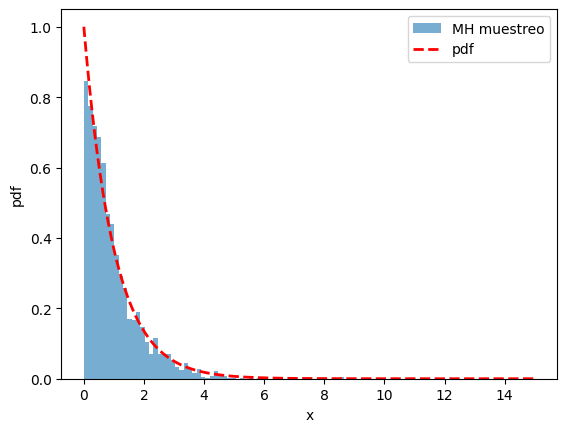

In [5]:
plt.hist(mcmc_samples, bins=60, density=True, alpha=0.6, label="MH muestreo")
plt.plot(x_plot, p_plot, 'r--', linewidth=2, label=f"pdf")
plt.xlabel('x')
plt.ylabel('pdf')
plt.legend()
plt.show()

In [6]:
# I ≈ mean( f(x_i) / p(x_i) )
f_values = np.array([f(x) for x in mcmc_samples])
p_values = p(mcmc_samples)

integral_approximation = np.mean(f_values / p_values)
print(f"Monte Carlo M-H: {integral_approximation:.5f}")

true_result, _ = integrate.quad(f, 0, np.inf)
print(f"scipy quad: {true_result:.5f}")

Monte Carlo M-H: 0.60109
scipy quad: 0.60000


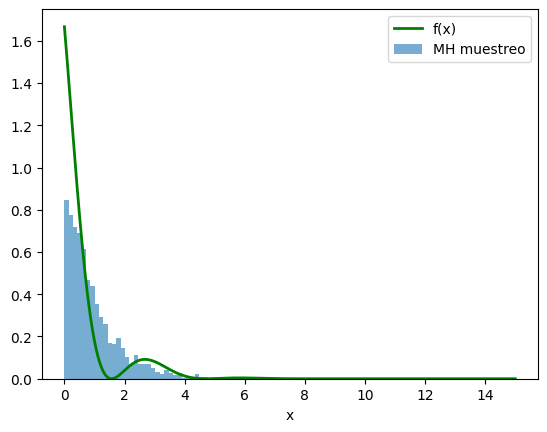

In [7]:
plt.plot(x_plot, f_plot / true_result, 'g-', linewidth=2, label="f(x)") # escalado por el area total
plt.hist(mcmc_samples, bins=60, density=True, alpha=0.6, label="MH muestreo")
plt.xlabel("x")
plt.legend()
plt.show()

## Ejemplo 2D

In [8]:
np.random.normal([2,2],1) # genera dos variables independientes con distribucion gaussiana

array([1.684379  , 3.62146172])

In [9]:
from scipy.stats import multivariate_normal

def f2d(x, y):
    #return (np.cos(x)**2) * (np.cos(y)**2)# * np.exp(-(x**2 + y**2))
    return np.cos(np.sqrt(x**2+y**2))**2 * np.exp(-(x**2 + y**2))

def p2d(x, y, sigma=1.0):
    puntos = np.stack([x, y], axis=-1)
    return multivariate_normal.pdf(puntos, mean=[0, 0], cov=[[sigma, 0], [0, sigma]])


def metropolis_hastings_2d(target_pdf, steps=20000, burn_in=5000):
    samples = []
    current_pos = np.array([0.0, 0.0])

    for _ in range(steps):
        proposal_pos = np.random.normal(current_pos, 0.5)

        p_proposal = target_pdf(proposal_pos[0], proposal_pos[1])
        p_current = target_pdf(current_pos[0], current_pos[1])
        acceptance_ratio = p_proposal / p_current

        if np.random.uniform(0, 1) < acceptance_ratio:
            current_pos = proposal_pos

        samples.append(current_pos)

    return np.array(samples[burn_in:])

In [10]:
# Generar el muestreo
mcmc_samples_2d = metropolis_hastings_2d(p2d)

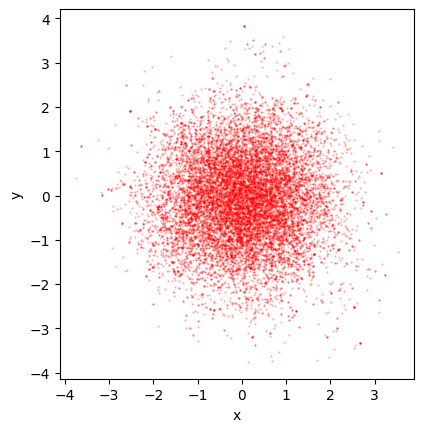

In [11]:
fig, ax = plt.subplots()
ax.scatter(mcmc_samples_2d[:,0], mcmc_samples_2d[:,1], s=0.3,color='r', alpha=0.3)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

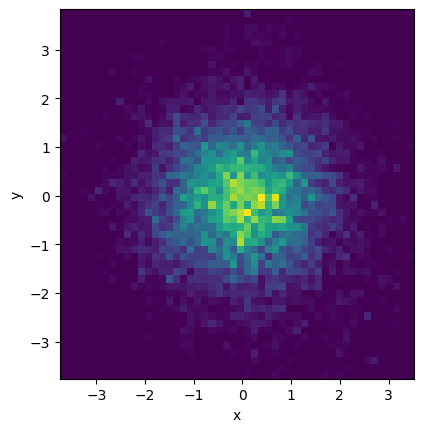

In [12]:
fig, ax = plt.subplots()
ax.hist2d(mcmc_samples_2d[:,0], mcmc_samples_2d[:,1], bins=50, cmap='viridis')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [13]:
# Monte Carlo I ≈ mean( f(xi,yi) / p(xi,yi) )
f2d_values = f2d(mcmc_samples_2d[:, 0], mcmc_samples_2d[:, 1])
p2d_values = p2d(mcmc_samples_2d[:, 0], mcmc_samples_2d[:, 1])
integral_approximation_2d = np.mean(f2d_values / p2d_values)

print(f"MCMC 2D: {integral_approximation_2d:.5f}")

true_2D, error_2D = integrate.dblquad(f2d, -5, 5, -5, 5)
print(f"SciPy's dblquad: {true_2D:.5f}")

MCMC 2D: 1.46945
SciPy's dblquad: 1.45117


In [14]:
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
Z = f2d(X, Y)

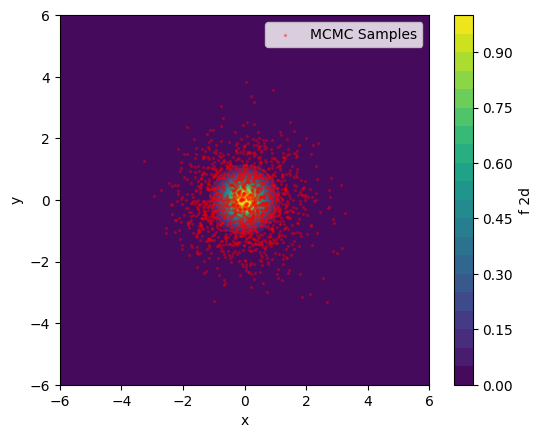

In [15]:
plt.figure()
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='f 2d')
plt.scatter(mcmc_samples_2d[::10, 0], mcmc_samples_2d[::10, 1], s=2, c='red', alpha=0.3, label='MCMC Samples')
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

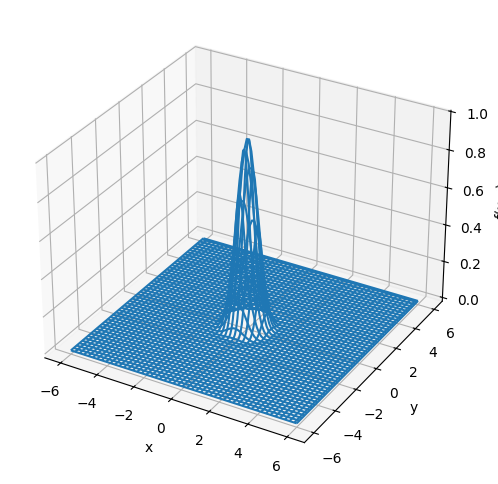

In [16]:
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': '3d'})
ax.plot_wireframe(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
plt.show()

# Ejercicio
1. Crear una muestra de una distribucion de la forma $$p(x,y) \propto e^{-(x^2-y^2)^2}$$
2. Potencial de Woods-Saxon, con la distribucion de Boltzmann
   $$U(r) = \frac{-V_0}{1 + e^{(r - R) / a}}$$
   $$p(x,y) \propto e^{-U/kT}$$